In [9]:
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

In [10]:
np.random.seed(0)

In [11]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

chainsaw
fire
fireworks
gunshot


In [12]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
new_dataset_dir = "src/classification/datasets/new_dataset/melvecs/"
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [13]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol


idx = 0


In [14]:
# TRANSFORMATION ON FEATURE VECTOR

def add_noise(feature_vector, snr_db=20):
    """Adds white noise to a feature vector based on the given SNR (Signal-to-Noise Ratio)."""
    power_signal = np.mean(feature_vector ** 2)
    power_noise = power_signal / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(power_noise), feature_vector.shape)
    return feature_vector + noise

def shifting(feature_vector, shift_max=20):
    """Shifts mel spectrogram feature vectors along the time axis by a random shift between 0 and shift_max."""
    shift = np.random.randint(0, shift_max)
    return np.roll(feature_vector, shift, axis=0)  # Rolling along the first axis

In [ ]:
# FEATURE EXTRACTION FROM FILE

naudio_new = 25

X_melvec = []
y_melvec = []
X_melvec_aug = []
y_melvec_aug = []


for classname in classnames:
    for idx in range(naudio_new):  # Assuming files are named from 1 to 40
        file_path = os.path.join(new_dataset_dir, f"{classname}_{idx:02d}.npy")
        if os.path.exists(file_path):
            featvec = np.load(file_path)
            featvec_shifted = shifting(featvec)  # Apply shifting transformation
            featvec_noisy = add_noise(featvec)  # Apply noise transformation
            X_melvec.append(featvec.flatten())
            y_melvec.append(classname)
            
            X_melvec_aug.append(featvec.flatten())
            X_melvec_aug.append(featvec_shifted.flatten())
            X_melvec_aug.append(featvec_noisy.flatten())
            y_melvec_aug.append(classname)
            y_melvec_aug.append(classname)
            y_melvec_aug.append(classname)
        else:
            print(f"Warning: File {file_path} not found.")

X_melvec = np.array(X_melvec)
y_melvec = np.array(y_melvec)
X_melvec_aug = np.array(X_melvec_aug)
y_melvec_aug = np.array(y_melvec_aug)

"""
np.save(fm_dir + "X_new_dataset.npy", X_new_dataset)
np.save(fm_dir + "y_new_dataset.npy", y_new_dataset)
np.save(fm_dir + "X_new_dataset_aug.npy", X_new_dataset_aug)
np.save(fm_dir + "y_new_dataset_aug.npy", y_new_dataset_aug)
"""

print(f"Shape of the new feature matrix: {X_melvec.shape}")
print(f"Number of labels in new dataset: {len(y_melvec)}")

print(f"Shape of the new feature matrix with data augmentation: {X_melvec_aug.shape}")
print(f"Number of labels in new dataset with data augmentation: {len(y_melvec_aug)}")


print(X_melvec_aug.shape)


Shape of the new feature matrix: (63, 400)
Number of labels in new dataset: 63
Shape of the new feature matrix with data augmentation: (189, 400)
Number of labels in new dataset with data augmentation: 189
(189, 400)


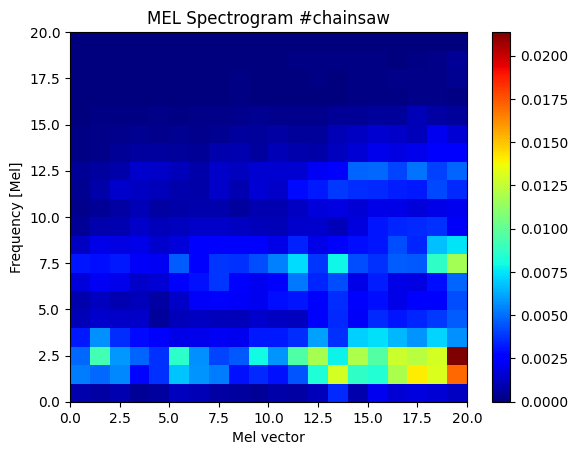

<Figure size 640x480 with 0 Axes>

In [97]:
# plot de melspectrogram

index = 12
         
import argparse
import matplotlib.pyplot as plt
from classification.utils.plots import plot_specgram

melvec_plotted = X_melvec[index]
class_plotted = y_melvec[index]

plt.figure()
plot_specgram(
    melvec_plotted.reshape((20, 20)),
    ax=plt.gca(),
    is_mel=True,
    title=f"MEL Spectrogram #{class_plotted}",
    xlabel="Mel vector",
)
plt.draw()
plt.pause(0.001)
plt.clf()

FINAL MODEL SAVE

In [40]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Directories
fm_dir = "data/feature_matrices/"
model_dir = "data/models/"
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

"""
# Load datasets
X_melvec_aug = np.load(fm_dir + "X_new_dataset_aug.npy")  # Original dataset
y_melvec_aug = np.load(fm_dir + "y_new_dataset_aug.npy")

X_melvec = np.load(fm_dir + "X_basic.npy")  # Original dataset
y_melvec = np.load(fm_dir + "y_basic.npy")
"""

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_melvec, y_melvec, test_size=0.3, stratify=y_melvec)

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_melvec_aug, y_melvec_aug, test_size=0.3, stratify=y_melvec_aug
)

# ===== TRAIN MODEL WITH PCA =====
pca = PCA(n_components=0.99)  # Keep 99% variance
X_train_aug_pca = pca.fit_transform(X_train_aug)
X_test_aug_pca = pca.transform(X_test_aug)  # Apply the same transformation to test data
print(f"Number of principal features kept: {pca.n_components_}")

# Save the PCA model separately
pca_filename = os.path.join(model_dir, "pca.pickle")
with open(pca_filename, "wb") as pca_file:
    pickle.dump(pca, pca_file)
print(f"\nPCA model saved as {pca_filename}")

# Train the Random Forest model on PCA-reduced features
rf_model_pca = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model_pca.fit(X_train_aug_pca, y_train_aug)

# Save the model trained **with PCA**
rf_filename_pca = os.path.join(model_dir, "mod_pca.pickle")
with open(rf_filename_pca, "wb") as rf_file:
    pickle.dump(rf_model_pca, rf_file)
print(f"\nRandom Forest model WITH PCA saved as {rf_filename_pca}")

# ===== TRAIN MODEL WITHOUT PCA =====
rf_model_no_pca = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model_no_pca.fit(X_train_aug, y_train_aug)  # Train directly on raw `X_aug` features

# Save the model trained **without PCA**
rf_filename_no_pca = os.path.join(model_dir, "mod_no_pca.pickle")
with open(rf_filename_no_pca, "wb") as rf_file:
    pickle.dump(rf_model_no_pca, rf_file)
print(f"\nRandom Forest model WITHOUT PCA saved as {rf_filename_no_pca}")

# ===== TRAIN MODEL WITHOUT DATA TRANSFORMATION (Original Data `X_basic`) =====
rf_model_no_transform = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model_no_transform.fit(X_train, y_train)  # Train on untransformed data

# Save the model trained **on X_basic (original features)**
rf_filename_no_transform = os.path.join(model_dir, "mod_no_aug.pickle")
with open(rf_filename_no_transform, "wb") as rf_file:
    pickle.dump(rf_model_no_transform, rf_file)
print(f"\nRandom Forest model WITHOUT DATA TRANSFORMATION saved as {rf_filename_no_transform}")




# ===== TRAIN MODEL WITH NORMALIZATION =====
X_train_normalized = []
X_test_normalized = []
for i in range(len(X_train)):
    X_train_normalized.append(X_train[i]/np.linalg.norm(X_train[i]))

for i in range(len(X_test)):
    X_test_normalized.append(X_test[i]/np.linalg.norm(X_test[i]))
    

# Train the model on normalized features
rf_model_normalized = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model_normalized.fit(X_train_normalized, y_train)

# Save the model trained **with normalization**
rf_filename_normalized = os.path.join(model_dir, "mod_norm_no_aug.pickle")
with open(rf_filename_normalized, "wb") as rf_file:
    pickle.dump(rf_model_normalized, rf_file)
print(f"\nRandom Forest model WITH NORMALIZATION saved as {rf_filename_normalized}")






# ===== EVALUATION FUNCTION (optional but useful) =====
def evaluate_model(model, X_test, y_test, description):
    predict = model.predict(X_test)

    # Compute metrics for each class
    classes = np.unique(y_test)
    precision_per_class = precision_score(y_test, predict, average=None, labels=classes)
    recall_per_class = recall_score(y_test, predict, average=None, labels=classes)

    test_accuracy_per_class = []
    conf_matrix = confusion_matrix(y_test, predict, labels=classes)

    for i, cls in enumerate(classes):
        class_accuracy = conf_matrix[i, i] / conf_matrix[i, :].sum()
        test_accuracy_per_class.append(class_accuracy)

    # Cross-validation accuracy
    cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)

    # Print results
    print(f"\n=== {description} ===")
    print(f"Test Accuracy (Overall): {np.mean(predict == y_test):.4f}")
    print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

    print("\nPer-Class Metrics:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}:")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  Accuracy: {test_accuracy_per_class[i]:.4f}")

# Evaluate all models
evaluate_model(rf_model_pca, X_test_aug_pca, y_test_aug, "Model WITH PCA")
evaluate_model(rf_model_no_pca, X_test, y_test, "Model WITHOUT PCA")
evaluate_model(rf_model_no_transform, X_test, y_test, "Model WITHOUT DATA TRANSFORMATION")
evaluate_model(rf_model_normalized, X_test_normalized, y_test, "Model WITH NORMALIZATION")


Number of principal features kept: 61

PCA model saved as data/models/pca.pickle

Random Forest model WITH PCA saved as data/models/mod_pca.pickle

Random Forest model WITHOUT PCA saved as data/models/mod_no_pca.pickle

Random Forest model WITHOUT DATA TRANSFORMATION saved as data/models/mod_no_aug.pickle

Random Forest model WITH NORMALIZATION saved as data/models/mod_norm_no_aug.pickle

=== Model WITH PCA ===
Test Accuracy (Overall): 0.7222
Mean CV Accuracy: 0.6222

Per-Class Metrics:
Class chainsaw:
  Precision: 0.7308
  Recall: 0.8261
  Accuracy: 0.8261
Class fire:
  Precision: 0.6250
  Recall: 0.9091
  Accuracy: 0.9091
Class fireworks:
  Precision: 0.7647
  Recall: 0.5652
  Accuracy: 0.5652
Class gunshot:
  Precision: 0.8667
  Recall: 0.5909
  Accuracy: 0.5909

=== Model WITHOUT PCA ===
Test Accuracy (Overall): 0.8667
Mean CV Accuracy: 0.5333

Per-Class Metrics:
Class chainsaw:
  Precision: 0.7778
  Recall: 1.0000
  Accuracy: 1.0000
Class fire:
  Precision: 0.8889
  Recall: 1.0000

MEAN ACCURACY ON 100 ITERATIONS

In [18]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from classification.utils.utils import accuracy

# Directories for saving models
model_dir = "data/models/"
os.makedirs(model_dir, exist_ok=True)

# Ensure dataset (X_aug, y_aug) exists
try:
    X = X_aug
    y = y_aug
except NameError:
    raise ValueError("X_aug and y_aug must be defined before running this script.")

# Number of iterations
num_iterations = 20

# Lists to store scores
accuracy_scores = []
cv_accuracy_scores = []

for i in range(num_iterations):
    print(f"\nIteration {i + 1}/{num_iterations}")

    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=i  # Different splits per iteration
    )

    # Train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=400,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=i  # Different initialization per iteration
    )
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute overall accuracy
    test_accuracy = accuracy(y_pred, y_test)
    accuracy_scores.append(test_accuracy)

    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)
    cv_accuracy_scores.append(mean_cv_accuracy)

    print(f"Test Accuracy: {test_accuracy:.4f} | Mean CV Accuracy: {mean_cv_accuracy:.4f}")

# Compute overall statistics
mean_test_accuracy = np.mean(accuracy_scores)
std_test_accuracy = np.std(accuracy_scores)

mean_cv_accuracy = np.mean(cv_accuracy_scores)
std_cv_accuracy = np.std(cv_accuracy_scores)

# Print final results
print("\n=== FINAL RESULTS AFTER 100 ITERATIONS ===")
print(f"Mean Test Accuracy: {mean_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")


ValueError: X_aug and y_aug must be defined before running this script.